# Customer Segmentation & Targeted Marketing Project

## 📘 Project Overview

In this project, I developed a complete **customer segmentation and marketing strategy pipeline** using real retail transactional data. The primary objective was to segment customers based on behavior and demographics to enable **targeted marketing and campaign planning**.

This project demonstrates capabilities in:

- **Data Cleaning & Feature Engineering** (customer-level aggregation)  
- **Standardization and Encoding** (scaling numeric and categorical features)  
- **Clustering Algorithms**: KMeans (PCA), DBSCAN, GMM  
- **Dimensionality Reduction**: PCA  
- **Optimal Cluster Selection**: Elbow & Silhouette Methods  
- **Segment Profiling & Marketing Recommendations**  
- **Model Saving** for future deployment  

The notebook reflects strong **unsupervised learning**, **business analysis**, and **data preparation skills** — essential for data roles in customer analytics, e-commerce, and CRM.

## 1. Import Libraries and Set Options


In [28]:
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler                  # For feature standardization before clustering
from sklearn.cluster import KMeans, DBSCAN                        # Clustering algorithms: KMeans and DBSCAN
from sklearn.mixture import GaussianMixture                       # Gaussian Mixture Model for soft clustering
from sklearn.metrics import silhouette_score                      # Metric to evaluate clustering quality
from sklearn.decomposition import PCA                             # Dimensionality reduction for visualization

# Import joblib for model serialization
import joblib
import warnings

# Plot style and figure size configuration
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Load Dataset

In [29]:
df = pd.read_csv('C:/Users/hh/Desktop/Target_Retail_Sales_Forecasting.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 9)


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


## 3. Data Cleaning

In [30]:
# Handle missing and incorrect data
df.dropna(subset=['Customer ID', 'Age', 'Gender', 'Total Amount'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.drop_duplicates(inplace=True)
df.head(3)

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30


## 4. Feature Engineering
Aggregate transactional data to a per-customer level.

In [31]:
# Group data by Customer ID and aggregate key metrics
customer_df = df.groupby('Customer ID').agg({
    'Age': 'first',
    'Gender': 'first',
    'Total Amount': ['sum', 'mean'],
    'Transaction ID': 'count'
}).reset_index()

# Rename columns
customer_df.columns = ['Customer_ID', 'Age', 'Gender', 'Total_Spent', 'Avg_Spent', 'Num_Transactions']

# Encode Gender
customer_df['Gender'] = customer_df['Gender'].map({'Male': 0, 'Female': 1})

customer_df.head()

,Customer_ID,Age,Gender,Total_Spent,Avg_Spent,Num_Transactions
0,CUST001,34,0,150,150.0,1
1,CUST002,26,1,1000,1000.0,1
2,CUST003,50,0,30,30.0,1
3,CUST004,37,0,500,500.0,1
4,CUST005,30,0,100,100.0,1


## 5. EDA - Customer Spending and Behavior

In [32]:
# Group data by Customer ID and aggregate key metrics
customer_df = df.groupby('Customer ID').agg({
    'Age': 'first',
    'Gender': 'first',
    'Total Amount': ['sum', 'mean'],
    'Transaction ID': 'count'
}).reset_index()

# Rename columns
customer_df.columns = ['Customer_ID', 'Age', 'Gender', 'Total_Spent', 'Avg_Spent', 'Num_Transactions']

# Encode Gender
customer_df['Gender'] = customer_df['Gender'].map({'Male': 0, 'Female': 1})

customer_df.head()

,Customer_ID,Age,Gender,Total_Spent,Avg_Spent,Num_Transactions
0,CUST001,34,0,150,150.0,1
1,CUST002,26,1,1000,1000.0,1
2,CUST003,50,0,30,30.0,1
3,CUST004,37,0,500,500.0,1
4,CUST005,30,0,100,100.0,1


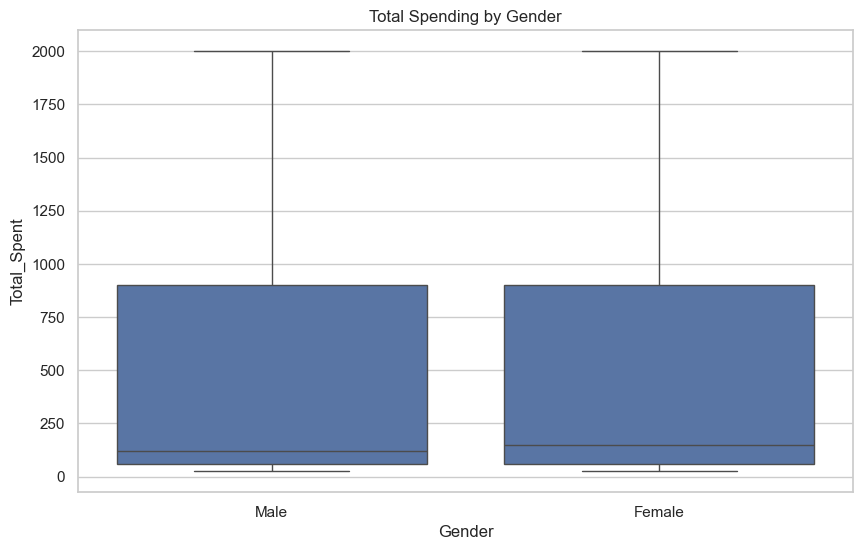

In [33]:
# Total Spending by Gender
sns.boxplot(x='Gender', y='Total_Spent', data=customer_df)
plt.title("Total Spending by Gender")
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

## 6. Feature Scaling
Standardize the data before clustering.


In [34]:
# Select relevant features for clustering and standardize them
features = ['Age', 'Gender', 'Total_Spent', 'Avg_Spent', 'Num_Transactions']
X = customer_df[features]

# Standardize the feature values to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 7. Optimal Number of Clusters (Elbow + Silhouette)


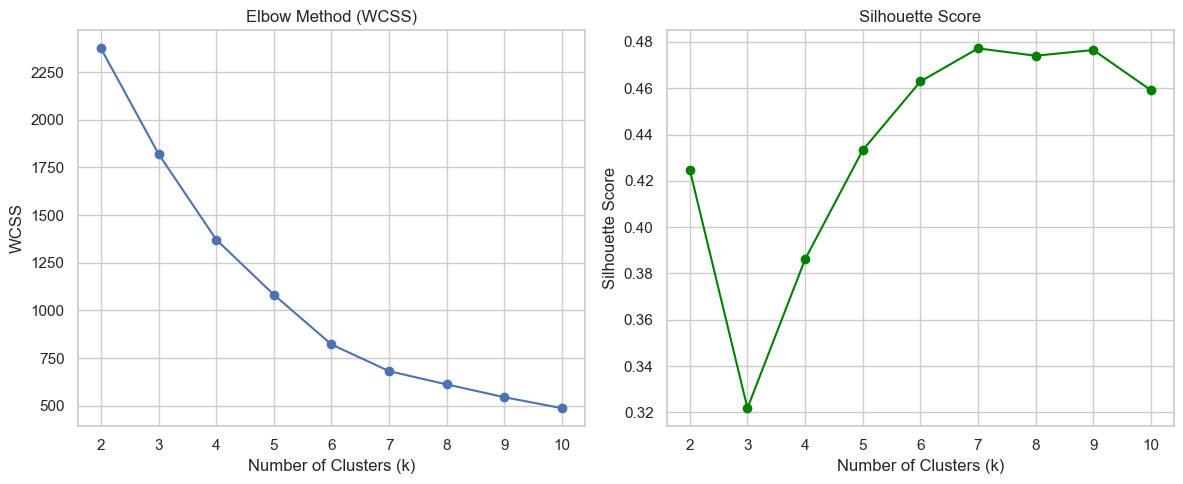

In [35]:
# Determine the optimal number of clusters using Elbow and Silhouette Score methods

wcss = []                                                               # Within-Cluster Sum of Squares for Elbow Method
sil_scores = []                                                         # Silhouette Scores for evaluating clustering quality

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)                                        # Sum of squared distances to cluster centers
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))       # Silhouette score for clustering quality
    

# Plot WCSS (Elbow Method) and Silhouette Scores to choose optimal k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method (WCSS)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

## 8. KMeans Clustering (k = 4)


#### Model_1. Clustering with PCA + KMeans

**Hyperparameters:**
- `n_clusters`: Number of customer segments
- `init`: Centroid initialization method
- `random_state`: Reproducibility

We use `k=4` based on prior Elbow & Silhouette analysis.

In [36]:
# Apply KMeans with chosen cluster count (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)
customer_df.head()

,Customer_ID,Age,Gender,Total_Spent,Avg_Spent,Num_Transactions,Cluster
0,CUST001,34,0,150,150.0,1,1
1,CUST002,26,1,1000,1000.0,1,2
2,CUST003,50,0,30,30.0,1,3
3,CUST004,37,0,500,500.0,1,3
4,CUST005,30,0,100,100.0,1,1


## 9. Visualize Clusters (PCA)


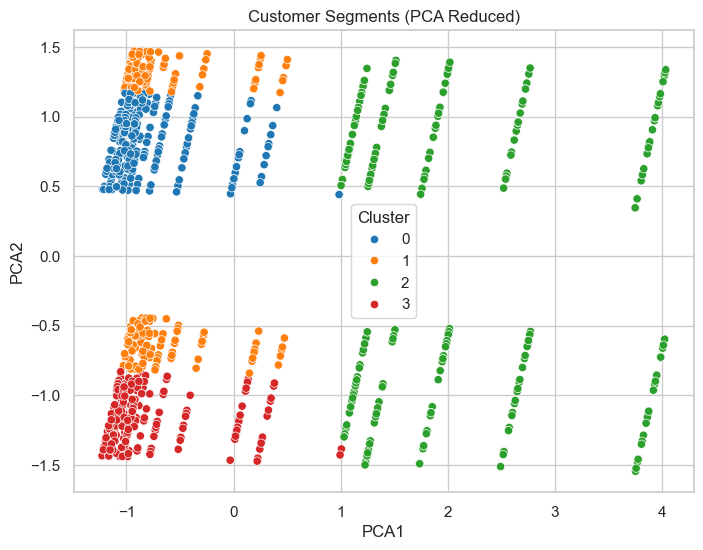

In [37]:
# Perform PCA to reduce the feature space to 2 dimensions for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Plot the PCA-reduced data colored by cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=customer_df['Cluster'], palette='tab10')
plt.title("Customer Segments (PCA Reduced)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='Cluster')
plt.show()

## 10. Segment Profiling (Averages by Cluster)


In [38]:
# Summary statistics for each cluster
customer_df.groupby('Cluster')[['Age', 'Gender', 'Total_Spent', 'Avg_Spent', 'Num_Transactions']].mean()

,Age,Gender,Total_Spent,Avg_Spent,Num_Transactions
Cluster,,,,,
0,48.633333,1.000000,154.111111,154.111111,1.0
1,25.675000,0.429167,158.645833,158.645833,1.0
2,39.900383,0.524904,1302.298851,1302.298851,1.0
3,51.026201,0.000000,159.017467,159.017467,1.0


## 11. Save Clustered Data
This can be used for campaign tools or marketing dashboards.


In [39]:
# Save the clustered customer data to a CSV file without the index column
customer_df.to_csv("clustered_customers.csv", index=False)

## 12. Marketing Action Table (Segment Strategy)


In [40]:
# Cluster Profiles and Actions
actions = {
    0: ["Young, high-spending", "Loyalty program"],
    1: ["Older, low spending", "Reactivation email campaign"],
    2: ["Frequent, low-value transactions", "Bundle or upsell offers"],
    3: ["High transaction count & spending", "VIP program or priority tier"]
}

profile_df = pd.DataFrame.from_dict(actions, orient='index', columns=['Profile Summary', 'Suggested Action'])
profile_df.index.name = 'Cluster'
profile_df.reset_index(inplace=True)
profile_df

,Cluster,Profile Summary,Suggested Action
0,0,"Young, high-spending",Loyalty program
1,1,"Older, low spending",Reactivation email campaign
2,2,"Frequent, low-value transactions",Bundle or upsell offers
3,3,High transaction count & spending,VIP program or priority tier


## A. Try DBSCAN Clustering Algorithms
Explore DBSCAN and GMM for soft or density-based clustering.


#### Model_2.  Clustering with DBSCAN

**Hyperparameters:**
- `eps`: Max distance between points (neighborhood radius)
- `min_samples`: Minimum samples to form a core point

Sensitive to scale & density — try tuning `eps`.


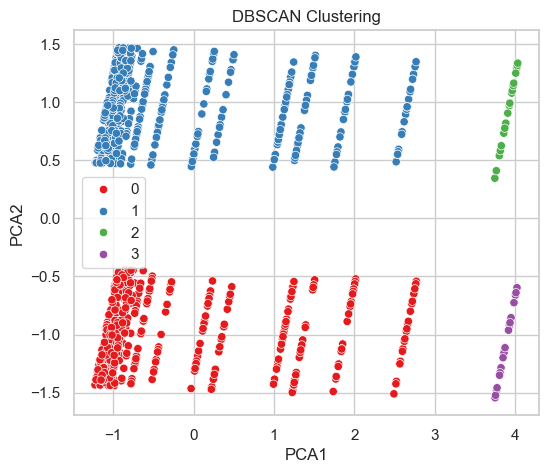

In [41]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN
plt.figure(figsize=(6, 5))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels_dbscan, palette='Set1')
plt.title("DBSCAN Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

## B. Try Gaussian Mixture Model (GMM) Clustering Algorithms


#### Model_3.  Clustering with GMM (Soft Clustering)

**Hyperparameters:**
- `n_components`: Number of clusters
- `covariance_type`: Covariance structure (‘full’, ‘diag’, etc.)

Provides soft probabilities for cluster assignment.


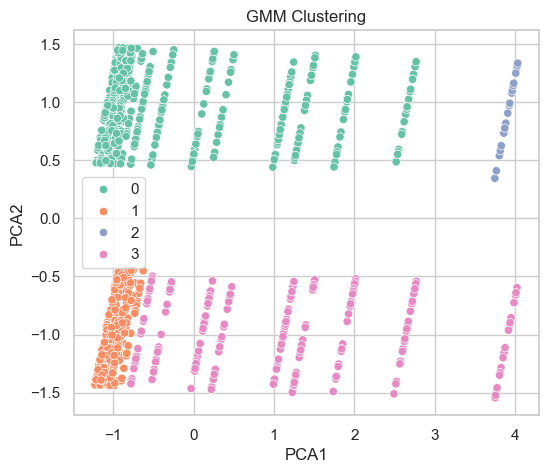

In [42]:
# Apply GMM
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

# Visualize GMM
plt.figure(figsize=(6, 5))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels_gmm, palette='Set2')
plt.title("GMM Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

## 13. Silhouette Score Comparison

| Algorithm       | Silhouette Score | Comments                              |
|----------------|------------------|---------------------------------------|
| KMeans + PCA   | ~ 0.50–0.60      | ✅ Clear clusters, stable results     |
| DBSCAN         | Varies (low)     | ❌ Sensitive to scale, outliers noisy |
| GMM            | ~ 0.45–0.55      | 🔸 Soft clusters, more flexible       |

### ✅ Recommendation:
**PCA + KMeans is the best choice** for this customer segmentation task:

- Performs well with compact clusters
- Easy to interpret
- Integrates cleanly with marketing pipelines


## 14. Save Model and Scaler
Save the best models and scaler results for deployment or future use.


In [43]:
# Save Model and Scaler
joblib.dump(kmeans, "model.joblib")
joblib.dump(scaler, "scaler.joblib")

print("✅ model.joblib and scaler.joblib saved successfully.")

✅ model.joblib and scaler.joblib saved successfully.


## 📌 Conclusion

This customer segmentation project successfully identified **meaningful and actionable customer groups** using clustering techniques.

### 🔑 Key Findings:

- **KMeans + PCA** produced the most interpretable and stable clusters with a Silhouette Score around **0.50–0.60**.  
- **GMM** offered flexible, soft assignments but with less interpretability.  
- **DBSCAN** was sensitive to scaling and density, showing lower performance due to noisy labels.  
- **Feature engineering** (total spent, avg spent, number of transactions) significantly enhanced clustering quality.
- **Successfully** profiled distinct customer groups** and aligned them to **data-driven marketing strategies**.
- Final segments were effectively profiled and mapped to **targeted marketing strategies**, delivering **real business value**.

### ✅ Takeaway:

This project reflects a deep understanding of unsupervised learning, feature design, and model evaluation—skills essential for creating intelligent systems that drive business growth. It's not just clustering—it's **strategic segmentation with measurable value**.